# K最近邻/k-Nearest Neighbor (kNN)

The kNN 分类器由2部分组成:

- 训练部分做的事情是啥呢？它只是把数据都读进去了，然后全记下来了。
- 那测试阶段呢？它会找到离它最近的N个训练样本，以他们中出现最多的类别作为它的类别
- 关于k的选择我们一般要交叉验证

In [1]:
# 测试一下各个库是否正常

import random
import numpy as np
from julyedu.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
# 载入CIFAR-10数据集
cifar10_dir = 'julyedu/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# 先了解一下训练集和测试集的维度等信息
print 'Training data shape: ', X_train.shape
print 'Training labels shape: ', y_train.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


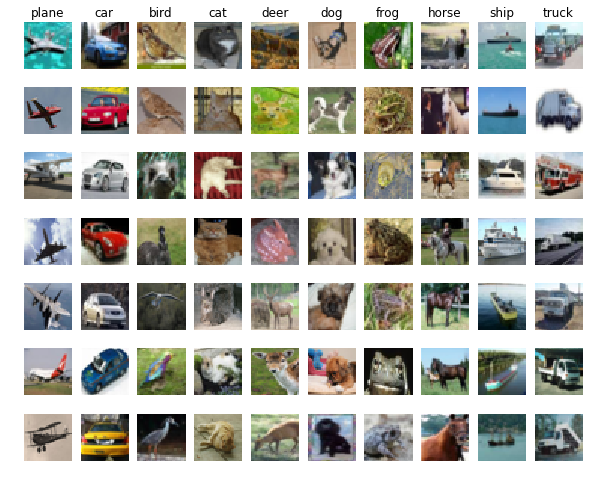

In [3]:
# 看看数据集中的一些样本：每个类别展示一些
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    # 一个类别中挑出一些
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [6]:
# 咱们下采样一下，因为样本有点多哦，所以咱们只挑一部分，这样会更有效率一些
num_training = 5000
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

In [7]:
# 咱们把图像数据展开成一个向量的形式
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print X_train.shape, X_test.shape

(5000, 3072) (500, 3072)


In [8]:
from classifiers import KNearestNeighbor

# 调用一下KNN分类器，然后训练(其实就是把样本都记下来) 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

接下来的测试阶段其实咱们，要对这500张测试样本，都做一遍训练集样本查找(找到最接近的N个)

In [7]:
# 不是那么高效的方式，用了2层for循环
dists = classifier.compute_distances_two_loops(X_test)

print dists.shape

(500, 5000)


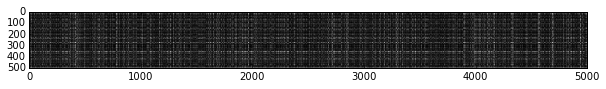

In [8]:
# 可以可视化一下这个结果(虽然没啥意义)，矩阵中的每个点都代表一个测试样本和一个训练样本之间的距离
plt.imshow(dists, interpolation='none')

然后就可以开始预测了

In [9]:
# 其实预测阶段的过程非常简单，因为刚才和5000个训练样本之间的距离已经算好了，咱们直接取topN样本看类别就可以了
y_test_pred = classifier.predict_labels(dists, k=1)

# 看下准确率
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print 'Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy)

Got 137 / 500 correct => accuracy: 0.274000


In [22]:
# 一层for循环的方式，高效一点
dists_one = classifier.compute_distances_one_loop(X_test)

# 少年，你没有想到吧，numpy内置了一些很高效的计算方式
# 比如，咱们比对一下，现在算出的这些个距离，和刚才2层for循环的是不是一样
difference = np.linalg.norm(dists - dists_one, ord='fro')
print 'Difference was: %f' % (difference, )
if difference < 0.001:
  print 'Good! The distance matrices are the same'
else:
  print 'Uh-oh! The distance matrices are different'

Difference was: 0.000000
Good! The distance matrices are the same


In [14]:
# 更高效的方式，不用for循环
dists_two = classifier.compute_distances_no_loops(X_test)

# 和前面一样，看看算的对不对咯
difference = np.linalg.norm(dists - dists_two, ord='fro')
print 'Difference was: %f' % (difference, )
if difference < 0.001:
  print 'Good! The distance matrices are the same'
else:
  print 'Uh-oh! The distance matrices are different'

Difference was: 0.000000
Good! The distance matrices are the same


In [11]:
# 闲的无聊，对比下没有向量化和向量化之后的计算速度
def time_function(f, *args):
  """
  Call a function f with args and return the time (in seconds) that it took to execute.
  """
  import time
  tic = time.time()
  f(*args)
  toc = time.time()
  return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print 'Two loop version took %f seconds' % two_loop_time

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print 'One loop version took %f seconds' % one_loop_time

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print 'No loop version took %f seconds' % no_loop_time

# you should see significantly faster performance with the fully vectorized implementation

Two loop version took 52.685231 seconds
One loop version took 44.575945 seconds
No loop version took 0.529489 seconds


### 交叉验证

刚才的预测阶段，咱们的K是自己指定的5，实际上我们是可以通过交叉验证来确定最合适的K的

In [ ]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []

idxes = range(num_training)
idx_folds = np.array_split(idxes, num_folds)
for idx in idx_folds:
#     mask = np.ones(num_training, dtype=bool)
#     mask[idx] = False
#     X_train_folds.append( (X_train[mask], X_train[~mask]) )
#     y_train_folds.append( (y_train[mask], y_train[~mask]) )
    X_train_folds.append( X_train[idx] )
    y_train_folds.append( y_train[idx] )
    
k_to_accuracies = {}


import sys
classifier = KNearestNeighbor()
Verbose = False
for k in k_choices:
    if Verbose: print "processing k=%f" % k
    else: sys.stdout.write('.')
    k_to_accuracies[k] = list()
    for num in xrange(num_folds):
        if Verbose: print "processing fold#%i/%i" % (num, num_folds)
        
        X_cv_train = np.vstack( [ X_train_folds[x] for x in xrange(num_folds) if x != num ])
        y_cv_train = np.hstack( [ y_train_folds[x].T for x in xrange(num_folds) if x != num ])
        
        X_cv_test = X_train_folds[num]
        y_cv_test = y_train_folds[num]

        # 训练KNN分类器
        classifier.train(X_cv_train, y_cv_train)
        
        # 计算和训练集之间图片的距离
        dists = classifier.compute_distances_no_loops(X_cv_test)
        
        y_cv_test_pred = classifier.predict_labels(dists, k=k)
        # 计算和预测
        num_correct = np.sum(y_cv_test_pred == y_cv_test)
        k_to_accuracies[k].append( float(num_correct) / y_cv_test.shape[0] )


# 输出计算的准确率
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print 'k = %d, accuracy = %f' % (k, accuracy)

..

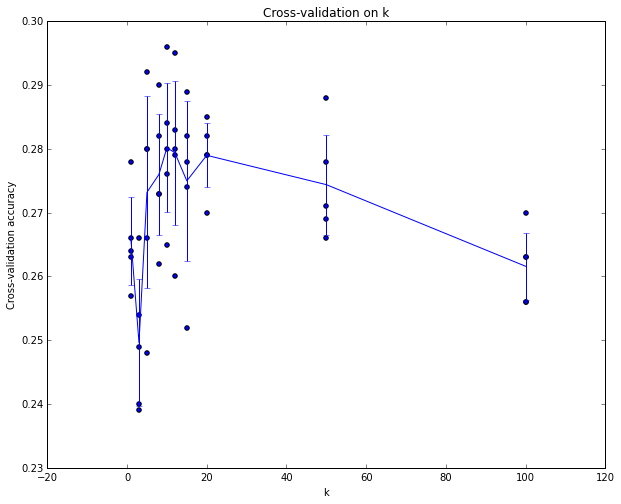

In [24]:
# 画一下结果
for k in k_choices:
  accuracies = k_to_accuracies[k]
  plt.scatter([k] * len(accuracies), accuracies)

accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [32]:
# 根据上面交叉验证的结果，咱们确定最合适的k值为6，然后重新训练和测试一遍吧
best_k = 6

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# 输出准确度
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print 'Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy)

Got 141 / 500 correct => accuracy: 0.282000
